# Import All Modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import spacy
from collections import Counter
from wordcloud import WordCloud
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

#  Import Dataset

In [3]:
# Define column names
columns = ['ID', 'Entity', 'Sentiment', 'Text']

# Load the dataset with defined column names
df_train = pd.read_csv('data/twitter_training.csv', names=columns)
df_val = pd.read_csv('data/twitter_validation.csv', names=columns)

# Sample 1% of the training data
df_train = df_train.sample(frac=0.001, random_state=42)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 34877 to 14208
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         75 non-null     int64 
 1   Entity     75 non-null     object
 2   Sentiment  75 non-null     object
 3   Text       74 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.9+ KB


In [5]:
df_train.head()

,ID,Entity,Sentiment,Text
34877,6789,Fortnite,Irrelevant,He said told u I'm getting in that box of a br...
21704,4115,CS-GO,Positive,Yo this looks LIT! CS: GO / Overwatch combo
47008,5665,HomeDepot,Negative,@HomeDepot attention executive administrators....
7969,9369,Overwatch,Irrelevant,Guy has notified me and says that my name has ...
454,2476,Borderlands,Positive,F Loving the new DLC!!!. RhandlerR RhandlerR R...


In [6]:
df_train.describe()

,ID
count,75.000000
mean,6279.280000
std,3674.958391
min,130.000000
25%,2682.000000
50%,6168.000000
75%,9194.500000
max,13020.000000


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         1000 non-null   int64 
 1   Entity     1000 non-null   object
 2   Sentiment  1000 non-null   object
 3   Text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


In [8]:
df_val.head()

,ID,Entity,Sentiment,Text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [9]:
df_val.describe()

,ID
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


# Data Cleaning

In [10]:
missing_values = df_train.isnull().sum()
missing_values

ID           0
Entity       0
Sentiment    0
Text         1
dtype: int64

In [11]:
missing_values = df_val.isnull().sum()
missing_values

ID           0
Entity       0
Sentiment    0
Text         0
dtype: int64

In [12]:
# Convert NaN values to empty strings
df_train['Text'] = df_train['Text'].fillna('')

# Convert float values to strings
df_train['Text'] = df_train['Text'].astype(str)

# EDA

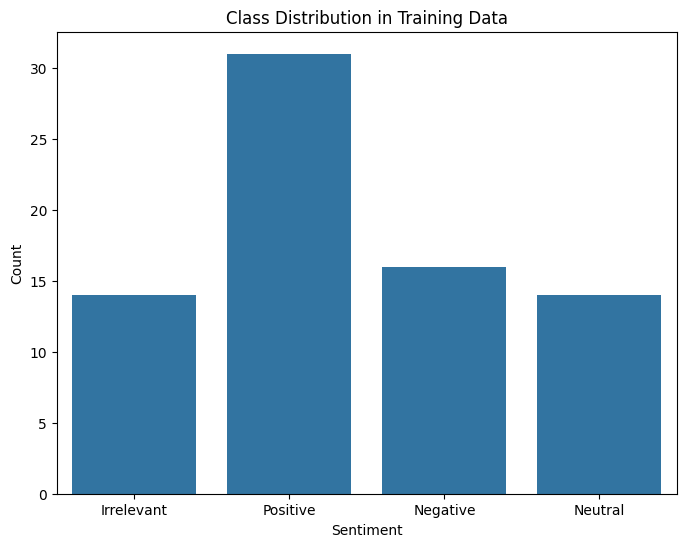

In [13]:
# Class Distribution of Sentiments in Training Data
plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='Sentiment')
plt.title('Class Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

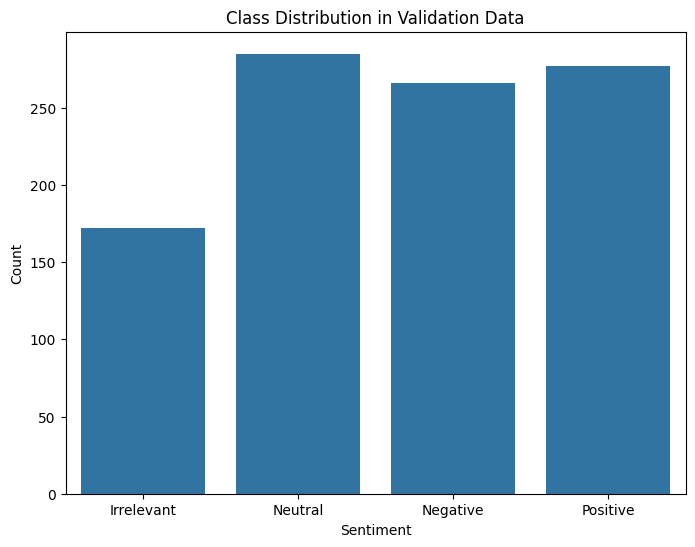

In [14]:
# Class Distribution of Sentiments in Validation Data:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_val, x='Sentiment')
plt.title('Class Distribution in Validation Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

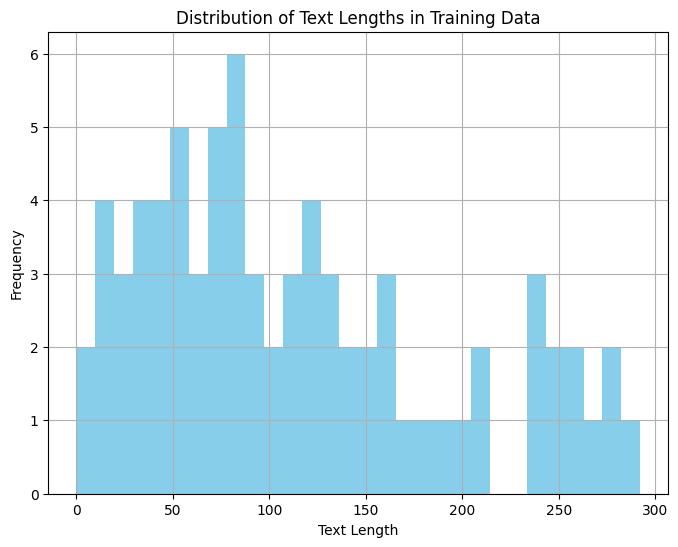

In [15]:
# Distribution of Text Lengths in Training Data
plt.figure(figsize=(8, 6))
df_train['Text'].str.len().hist(bins=30, color='skyblue')
plt.title('Distribution of Text Lengths in Training Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

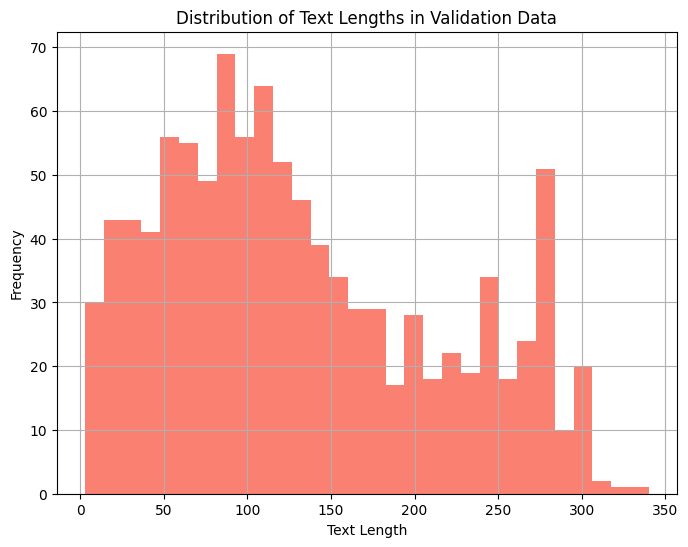

In [16]:
# Distribution of Text Lengths in Validation Data
plt.figure(figsize=(8, 6))
df_val['Text'].str.len().hist(bins=30, color='salmon')
plt.title('Distribution of Text Lengths in Validation Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

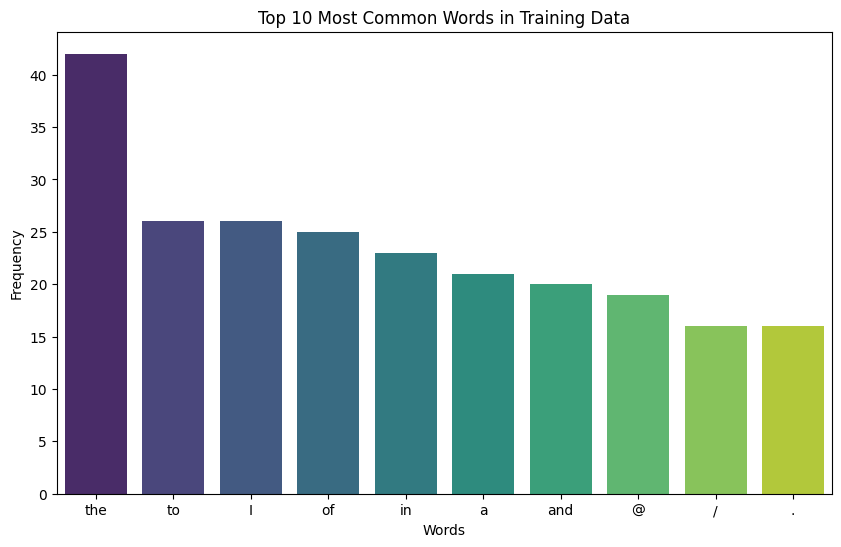

In [17]:
# Top 10 Most Common Words in Training Data
word_counts = Counter(" ".join(df_train['Text']).split()).most_common(10)
words, counts = zip(*word_counts)
plt.figure(figsize=(10, 6))
sns.barplot(x=words, y=counts, palette='viridis')
plt.title('Top 10 Most Common Words in Training Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

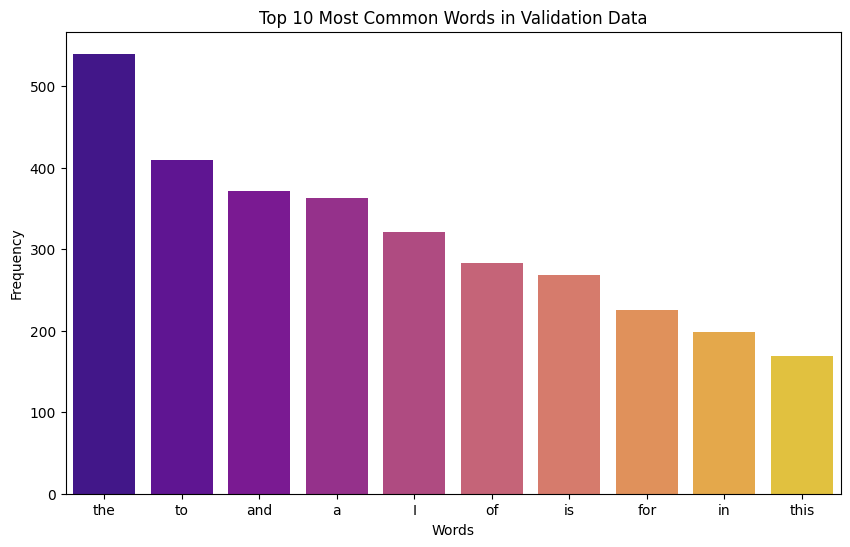

In [18]:
# Top 10 Most Common Words in Validation Data
word_counts_val = Counter(" ".join(df_val['Text']).split()).most_common(10)
words_val, counts_val = zip(*word_counts_val)
plt.figure(figsize=(10, 6))
sns.barplot(x=words_val, y=counts_val, palette='plasma')
plt.title('Top 10 Most Common Words in Validation Data')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

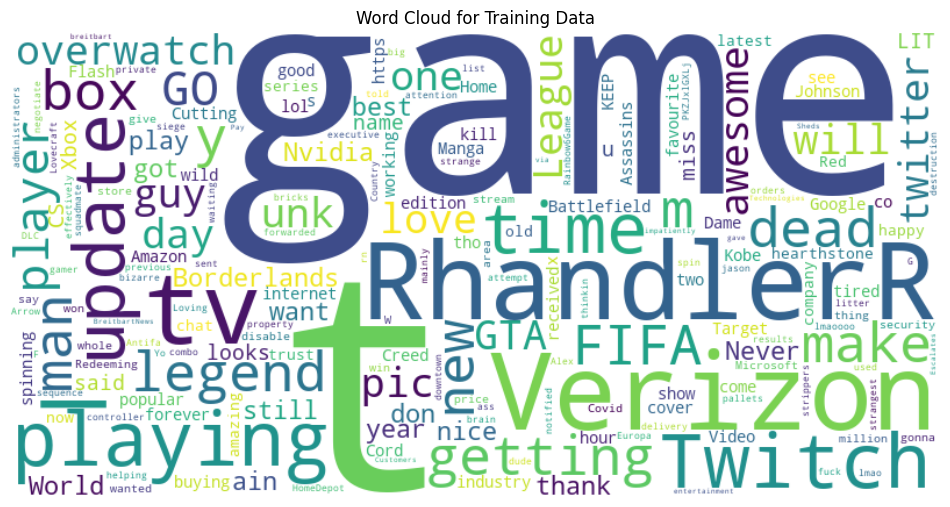

In [19]:
# Word Cloud for Training Data
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df_train['Text']))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Training Data')
plt.axis('off')
plt.show()

# Machine Learning Models

In [20]:
# Encode Sentiment Labels
label_encoder = LabelEncoder()
df_train['Sentiment'] = label_encoder.fit_transform(df_train['Sentiment'])
df_val['Sentiment'] = label_encoder.transform(df_val['Sentiment'])

In [21]:
# Text Classification using BERT
def train_text_classification_model(df_train):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    X_train_encoded = tokenizer(list(df_train['Text']), padding=True, truncation=True, return_tensors='pt')
    y_train_tensor = torch.tensor(df_train['Sentiment'].values)
    train_dataset = TensorDataset(X_train_encoded.input_ids, X_train_encoded.attention_mask, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.train()
    num_epochs = 3
    
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            labels = labels.long()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': loss.item()})

# Fine-tune text summarization model
def fine_tune_text_summarization_model(df_train, num_epochs=3):
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    inputs = tokenizer(list(df_train['Text']), return_tensors='pt', padding=True, truncation=True)
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    model.train()

    for epoch in range(num_epochs):
        progress_bar = tqdm(loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids, attention_mask = batch
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': loss.item()})

# Train text classification model with progress indicators
train_text_classification_model(df_train)

# Fine-tune text summarization model with progress indicators
fine_tune_text_summarization_model(df_train)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
# Function to train the sentiment analysis 
def train_sentiment_analysis_model(df_train):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    X_train_encoded = tokenizer(list(df_train['Text']), padding=True, truncation=True, return_tensors='pt')
    y_train_tensor = torch.tensor(df_train['Sentiment'].values)
    train_dataset = TensorDataset(X_train_encoded.input_ids, X_train_encoded.attention_mask, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    optimizer = AdamW(model.parameters(), lr=5e-5)
    model.train()
    num_epochs = 3
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids, attention_mask, labels = batch
            labels = labels.long()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            progress_bar.set_postfix({'loss': loss.item()})

# Train the sentiment analysis model
train_sentiment_analysis_model(df_train)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Function to predict sentiment type for a given sentence
def predict_sentiment(sentence):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    input_ids = tokenizer.encode(sentence, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        sentiment_type = label_encoder.inverse_transform([predicted_class])[0]
    return sentiment_type

sentence = "I love this product! It's amazing."
predicted_sentiment = predict_sentiment(sentence)
print("Predicted Sentiment:", predicted_sentiment)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Sentiment: Positive


In [24]:
def generate_summary(text):
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    input_text = "summarize: " + text
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    summary_ids = model.generate(
        input_ids,
        max_length=150,
        min_length=40,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True,
        num_return_sequences=3
    )
    
    summaries = [tokenizer.decode(summary_id, skip_special_tokens=True) for summary_id in summary_ids]
    unique_summaries = list(set(summaries)) 
    unique_summary = " ".join(unique_summaries[0].split())
    return unique_summary

sample_text = "Sharks are a group of elasmobranch fish characterized by a cartilaginous skeleton, five to seven gill slits on the sides of the head, and pectoral fins that are not fused to the head. Modern sharks are classified within the clade Selachimorpha and are the sister group to the Batoidea."
summary = generate_summary(sample_text)
print("Summary:", summary)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Summary: sharks are a group of elasmobranch fish characterized by a cartilaginous skeleton. modern sharks are classified within the clade Selachimorpha and are the sister group to the batoidea.


# Results and Visualization


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.261
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.16      0.17       172
           1       0.27      0.79      0.40       266
           2       0.75      0.01      0.02       285
           3       0.27      0.08      0.12       277

    accuracy                           0.26      1000
   macro avg       0.37      0.26      0.18      1000
weighted avg       0.39      0.26      0.18      1000



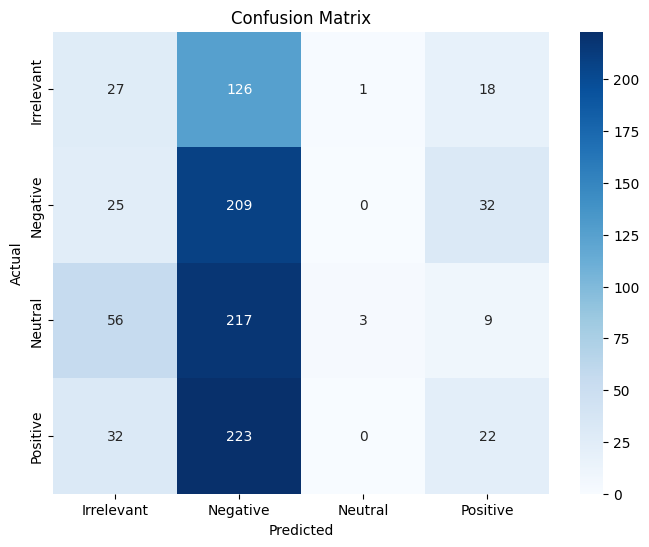

In [25]:
# Function to visualize confusion matrix
def visualize_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate text classification model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
X_val_encoded = tokenizer(list(df_val['Text']), padding=True, truncation=True, return_tensors='pt')
y_val_tensor = torch.tensor(df_val['Sentiment'].values)
val_dataset = TensorDataset(X_val_encoded.input_ids, X_val_encoded.attention_mask, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=8)
model.eval()
y_val_pred = []
with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = batch
        labels = labels.long()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        y_val_pred.extend(preds.tolist())

# Calculate accuracy
accuracy = accuracy_score(df_val['Sentiment'].values, y_val_pred)
print("Validation Accuracy:", accuracy)

# Generate classification report
classification_rep = classification_report(df_val['Sentiment'].values, y_val_pred)
print("Classification Report:")
print(classification_rep)

# Visualize confusion matrix
labels = label_encoder.classes_
visualize_confusion_matrix(df_val['Sentiment'].values, y_val_pred, labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation Accuracy: 0.24
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.14      0.16       172
           1       0.25      0.63      0.36       266
           2       0.00      0.00      0.00       285
           3       0.24      0.18      0.20       277

    accuracy                           0.24      1000
   macro avg       0.17      0.24      0.18      1000
weighted avg       0.17      0.24      0.18      1000



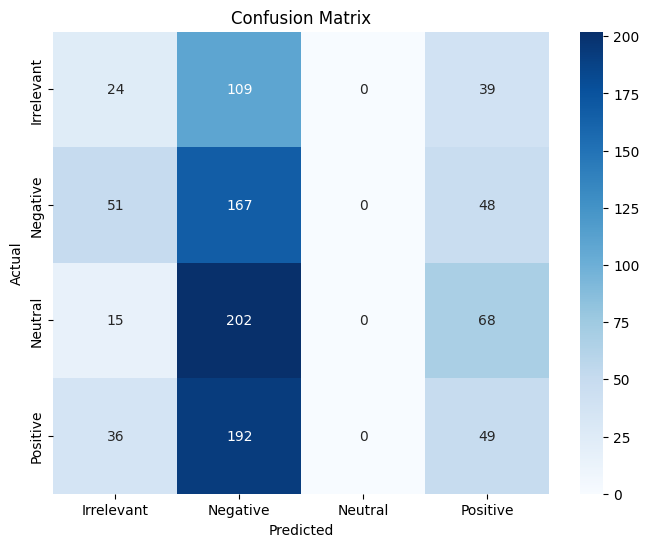

In [26]:
# Function to evaluate text classification model
def evaluate_sentiment_analysis_model(df_val):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))
    X_val_encoded = tokenizer(list(df_val['Text']), padding=True, truncation=True, return_tensors='pt')
    y_val_tensor = torch.tensor(df_val['Sentiment'].values)
    val_dataset = TensorDataset(X_val_encoded.input_ids, X_val_encoded.attention_mask, y_val_tensor)
    val_loader = DataLoader(val_dataset, batch_size=8)
    model.eval()
    y_val_pred = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            labels = labels.long()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            y_val_pred.extend(preds.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(df_val['Sentiment'].values, y_val_pred)
    print("Validation Accuracy:", accuracy)

    # Generate classification report
    classification_rep = classification_report(df_val['Sentiment'].values, y_val_pred)
    print("Classification Report:")
    print(classification_rep)

    # Visualize confusion matrix
    labels = label_encoder.classes_
    cm = confusion_matrix(df_val['Sentiment'].values, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Evaluate the sentiment analysis model
evaluate_sentiment_analysis_model(df_val)